<a href="https://colab.research.google.com/github/followviny/FDR/blob/main/cw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

C-TDC: Combined Target-Decoy Competition \\
T-TDC: Target-only Target-Decoy Competition \\
STDS: Separated Target-Decoy Search \\
STDS-PIT: Separated Target-Decoy Search with Percentage of Incorrect Targets adjustment \\

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### Data simulation

1. Determine if it's a native (correct) or foreign (incorrect) spectrum: \\
Native spectra: Generated by peptides present in the target database. \\
Foreign spectra: Not present in the target database. \\

2. Assign scores: \\

    **For native spectra**: \\
    True PSM score( $X_i$ ): Drawn from $ N(\mu=2.5,\sigma^2=1).$ \\
    Random target match score( $Y_i$ ): Drawn from $N(0,1)$.

    **For foreign spectra**: \\
    True PSM score( $X_i$ ): Set to $-\infty$ (no true match) \\
    Random target match score( $Y_i$ ): Drawn from $N(0,1)$.

3. Decoy PSM scores( $Z_i$ ): For all spectra(native and foreign), drawn from
$ N(0,1)$ .

4. Observed target PSM score( $W_i$ ): $W_i$ = max($X_i$, $Y_i$) .Represents the best match from the target database for spectrum i.

In [ ]:
def simulate_data(n_spectra, pi0):
    n_native = int((1 - pi0) * n_spectra)
    n_foreign = n_spectra - n_native

    Xi = np.zeros(n_spectra)
    Xi[:n_native] = np.random.normal(2.5, 1, n_native)  # that's true scores for native spectra
    Xi[n_native:] = -np.inf                             # and that's for foreign  (no match)

    Yi = np.random.normal(0, 1, n_spectra)              # random target match scores for all spectra
    Zi = np.random.normal(0, 1, n_spectra)              # decoy scores for all spectra

    Wi = np.maximum(Xi, Yi)                             # observed target scores

    is_correct = Xi > Yi

    return Xi, Yi, Zi, Wi, is_correct

### FDR methods

1. **STDS**


$\frac{\widehat{F}}{D}=\frac{|\{i:z_i>T\}|}{|\{i:w_i>T\}|}$ \\

"estimate the number of false
discoveries that exceed score T as the number of decoy PSMs
that exceed that score: |{i: $z_i$ > T}|"

In [ ]:
def fdr_stds(Xi, Yi, Zi, Wi, is_correct):
    all_scores = np.concatenate([Wi, Zi])
    thresholds = np.sort(np.unique(all_scores))      # this is for T from paper, just all possible thresholds

    est_fdrs = []
    act_fdrs = []

    for T in thresholds:
        D = np.sum(Wi >= T)
        F = np.sum(Zi >= T)
        if D == 0:
            est_fdr = 0.0
            act_fdr = 0.0
        else:
            est_fdr = F / D

            accepted = np.where(Wi >= T)[0]
            actual_F = len(accepted[~is_correct[accepted]])

            #incorrect = np.where((Wi >= T) & (Wi > Xi))[0]      # if W = max(Xi, Yi) is Yi, then it's false discovery, bc not Xi
            #actual_F = len(incorrect)
            act_fdr = actual_F / D

        est_fdrs.append(est_fdr)
        act_fdrs.append(act_fdr)

    return thresholds, np.array(est_fdrs), np.array(act_fdrs)

2. **STDS-PIT**

$\frac{\widehat{F}}{D}=\widehat{\pi_{0}}\frac{|\{i:z_{i}>T\}|}{|\{i:w_{i}>T\}|}$

$\widehat{\pi_{0}}$ using Storey's method. \\
"p-values of these target PSMs are computed based on the empirical CDF compiled purely from decoy scores; hence, these p values are computed relative to the null hypothesis that the spectrum is foreign." \\

$p(W_i)=1-\mathrm{CDF}(W_i)$ \\
$\mathrm{CDF}_{\mathrm{empirical}}(W_i)=\frac{\text{# of }Z_i\leq W_i}{\text{Total # of Decoy Scores}}$ \\

In [ ]:
#def comp_pi0(p_values, lambda_val=0.5):
    #n = len(p_values)
    #pi0_hat = np.sum(p_values > lambda_val) / ((1 - lambda_val) * n)  # Storey's formula
    #pi0_hat = min(pi0_hat, 1.0)
    #return pi0_hat


In [ ]:
def fdr_stds_pit(Xi, Yi, Zi, Wi, is_correct, pi0):
    all_scores = np.concatenate([Wi, Zi])
    thresholds = np.sort(np.unique(all_scores))

    Zi_sorted = np.sort(Zi)
    p_values_Wi = np.array([1.0 - np.searchsorted(Zi_sorted, Wi_i) / len(Zi_sorted) for Wi_i in Wi])   # empirical cdf (ECDF)

    #pi0_hat = comp_pi0(p_values_Wi)
    pi0_hat = pi0

    est_fdrs = []
    act_fdrs = []

    for T in thresholds:
        D = np.sum(Wi >= T)
        F = np.sum(Zi >= T)
        if D == 0:
            est_fdr = 0.0
            act_fdr = 0.0
        else:
            est_fdr = pi0_hat * F / D

            accepted = np.where(Wi >= T)[0]
            actual_F = len(accepted[~is_correct[accepted]])

            #incorrect = np.where((Wi >= T) & (Wi > Xi))[0]
            #actual_F = len(incorrect)
            act_fdr = actual_F / D
        est_fdrs.append(est_fdr)
        act_fdrs.append(act_fdr)

    return thresholds, np.array(est_fdrs), np.array(act_fdrs)

3. **B-H**

In [ ]:
def fdr_bh(Xi, Yi, Zi, Wi, is_correct, pi0):
    Zi_sorted = np.sort(Zi)
    n = len(Wi)
    p_values = np.array([1.0 - np.searchsorted(Zi_sorted, Wi_i) / len(Zi_sorted) for Wi_i in Wi])

    #pi0_hat = comp_pi0(p_values)
    pi0_hat = pi0

    sorted_indices = np.argsort(p_values)
    sorted_pvalues = p_values[sorted_indices]
    sorted_is_correct = is_correct[sorted_indices]

    q_values = sorted_pvalues * n / (np.arange(1, n + 1))
    min_q = 1.0
    for i in range(n-1, -1, -1):
        min_q = min(min_q, q_values[i])
        q_values[i] = min_q

    q_values *= pi0_hat
    q_values = np.minimum(1.0, q_values)

    unsorted_qvalues = np.empty(n) # back to orig ord
    unsorted_qvalues[sorted_indices] = q_values

    sorted_indices_desc = np.argsort(-Wi) # Wi desc
    sorted_Wi_desc = Wi[sorted_indices_desc]
    sorted_qvalues_desc = unsorted_qvalues[sorted_indices_desc]
    sorted_is_correct_desc = is_correct[sorted_indices_desc]
    n_disc = np.arange(1, n + 1)

    cumulative_false_discoveries = np.cumsum(~sorted_is_correct_desc)
    actual_fdrs = cumulative_false_discoveries / n_disc
    est_fdrs = sorted_qvalues_desc
    #print(f"Estimated pi0 (from BH): {pi0_hat}")

    return n_disc, est_fdrs, actual_fdrs

4. **Mix-Max**

$\hat{F_0}=\hat{\pi_0}\times|\{i{:}z_i>T\}|$ \
$\hat{F_1}=(1-\hat{\pi_0})\cdot\sum_{z_{j}>T}\left[\frac{\sum_{k}1_{w_{k}\leq z_{j}}-\hat{\pi}_{0}\sum_{k}1_{z_{k}\leq z_{j}}}{(1-\hat{\pi}_{0})n_{\Sigma}}/\frac{\sum_{k}1_{z_{k}\leq z_{j}}}{n_{\Sigma}}\right]_{[0,1]}$ \
$\hat{F\mkern-3mu}=\hat{F_0}+\hat{F_1}$

In [ ]:
def fdr_mixmax(Xi, Yi, Zi, Wi, is_correct, pi0_hat):
    n_spectra = len(Wi)

    unique_z_vals, counts_z = np.unique(Zi, return_counts=True)
    n_unique_z = len(unique_z_vals)
    sorted_Wi = np.sort(Wi)
    sorted_Zi = np.sort(Zi)

    counts_w_leq_z = np.searchsorted(sorted_Wi, unique_z_vals, side='right')
    counts_z_leq_z = np.searchsorted(sorted_Zi, unique_z_vals, side='right')
    P_W_leq_z = (counts_w_leq_z - pi0_hat * counts_z_leq_z) / ((1 - pi0_hat) * n_spectra)
    P_Y_leq_z = counts_z_leq_z / n_spectra

    R_j = np.divide(P_W_leq_z, P_Y_leq_z)

    all_scores = np.sort(np.unique(np.concatenate([Wi, Zi])))
    est_fdrs = []
    act_fdrs = []

    for T in all_scores:
        D = np.sum(Wi > T)
        if D == 0:
            est_fdr = 0.0
            act_fdr = 0.0
        else:
            F_0 = pi0_hat * np.sum(Zi > T)

            idx = np.searchsorted(unique_z_vals, T, side='right')
            if idx >= n_unique_z:
                F_1 = 0.0
            else:
                R_j_T = R_j[idx:]
                counts_z_T = counts_z[idx:]
                F_1 = (1 - pi0_hat) * np.sum(R_j_T * counts_z_T)

            F_hat = F_0 + F_1
            est_fdr = F_hat / D

            accepted_indices = np.where(Wi > T)[0]
            actual_F = np.sum(~is_correct[accepted_indices])
            act_fdr = actual_F / D

        est_fdrs.append(est_fdr)
        act_fdrs.append(act_fdr)

    return all_scores, np.array(est_fdrs), np.array(act_fdrs)

5. **T-TDC**


$\mathrm{T-TDC}:=\frac{F_\mathrm{D}}{D_\mathrm{T}}$

Split the discoveries into: \\
Target discoveries: Indices where the target score $W_i$ exceeds the decoy score $Z_i$. \\
Decoy discoveries: Indices where the decoy score $Z_i$ exceeds the target score $W_i$. \\

$F_\mathrm{D}=D_\mathrm{D}=|\{i:Z_i>\max(W_i,T)\}|$ \\
$D_\mathrm{T}=|\{i : W_i>\max(Z_i,T)\}|$


In [ ]:
def fdr_ttdc(Xi, Yi, Zi, Wi):
    Si = np.maximum(Wi, Zi)               # combined dataset
    thresholds = np.sort(np.unique(Si))   # again all unique T

    est_fdrs = []
    act_fdrs = []

    for T in thresholds:
        accepted = np.where(Si >= T)[0]   # discoveries
        if len(accepted) == 0:
            est_fdr = 0.0
            act_fdr = 0.0
        else:
            Wi_accepted = Wi[accepted]
            Zi_accepted = Zi[accepted]
            target_idx = accepted[Wi_accepted > Zi_accepted]
            decoy_idx = accepted[Zi_accepted > Wi_accepted]

            D_T = len(target_idx)
            F_D = len(decoy_idx)

            if D_T == 0:
                est_fdr = 0.0
                act_fdr = 0.0
            else:
                est_fdr = F_D / D_T    # among targets db
                incorrect = np.where(Wi[target_idx] == Yi[target_idx])[0]
                actual_F_T = len(incorrect)
                act_fdr = actual_F_T / D_T
        est_fdrs.append(est_fdr)
        act_fdrs.append(act_fdr)

    return thresholds, np.array(est_fdrs), np.array(act_fdrs)

6. **C-TDC**

$\widehat{F_{\mathrm{C}}}=2F_{\mathrm{D}}\Rightarrow\frac{\widehat{F_{\mathrm{C}}}}{D_{\mathrm{C}}}=\frac{2F_{\mathrm{D}}}{D_{\mathrm{C}}}$

In [ ]:
def fdr_ctdc(Xi, Yi, Zi, Wi):
    Si = np.maximum(Wi, Zi)
    thresholds = np.sort(np.unique(Si))

    est_fdrs = []
    act_fdrs = []

    for T in thresholds:
        accepted = np.where(Si >= T)[0]
        D_C = len(accepted)             # total discoveries
        if D_C == 0:
            est_fdr = 0.0
            act_fdr = 0.0
        else:
            Wi_accepted = Wi[accepted]
            Zi_accepted = Zi[accepted]
            decoy_idx = accepted[Zi_accepted > Wi_accepted]
            F_D = len(decoy_idx)
            est_fdr = (2 * F_D) / D_C   # among concatenated db

            target_idx = accepted[Wi_accepted > Zi_accepted]
            incorrect_target = np.where(Wi[target_idx] == Yi[target_idx])[0]
            actual_F_C = len(incorrect_target) + F_D
            act_fdr = actual_F_C / D_C      # (false target disc + decoys) / total disc
        est_fdrs.append(est_fdr)
        act_fdrs.append(act_fdr)

    return thresholds, np.array(est_fdrs), np.array(act_fdrs)

## Results ✨

"The number of discoveries at a given FDR level α was defined as the largest
number of discoveries reported by the method for which the
estimated FDR was still ≤ α " \\
can take the maximum value of act_fdrs for all valid thresholds

In [ ]:
def get_act_fdr_alpha(est_fdrs, act_fdrs, alpha_values):
    actual_fdrs_alpha = []

    for alpha in alpha_values:
        valid_indices = np.where(est_fdrs <= alpha)[0]
        if len(valid_indices) > 0:
            actual_fdr = np.max(act_fdrs[valid_indices])
        else:
            actual_fdr = np.nan
        actual_fdrs_alpha.append(actual_fdr)

    return np.array(actual_fdrs_alpha)

In [ ]:
def run_simulations(n_spectra, pi0=0.5, n_runs=100):
    methods = ['STDS', 'STDS-PIT', 'T-TDC', 'C-TDC', 'B-H', 'Mix-Max']
    alpha_values = np.linspace(0.01, 0.1, 50)              # can change alphas
    n_alpha = len(alpha_values)

    ratio_dict = {method: np.full((n_runs, n_alpha), np.nan) for method in methods}

    for run in range(n_runs):
        Xi, Yi, Zi, Wi, is_correct = simulate_data(n_spectra, pi0)

        for method in methods:
            if method == 'STDS':
                thresholds, est_fdrs, act_fdrs = fdr_stds(Xi, Yi, Zi, Wi, is_correct)
            elif method == 'STDS-PIT':
                thresholds, est_fdrs, act_fdrs = fdr_stds_pit(Xi, Yi, Zi, Wi, is_correct, pi0)
            elif method == 'T-TDC':
                thresholds, est_fdrs, act_fdrs = fdr_ttdc(Xi, Yi, Zi, Wi)
            elif method == 'C-TDC':
                thresholds, est_fdrs, act_fdrs = fdr_ctdc(Xi, Yi, Zi, Wi)
            elif method == 'B-H':
                thresholds, est_fdrs, act_fdrs = fdr_bh(Xi, Yi, Zi, Wi, is_correct, pi0)
            elif method == 'Mix-Max':
                thresholds, est_fdrs, act_fdrs = fdr_mixmax(Xi, Yi, Zi, Wi, is_correct, pi0)

            actual_fdrs_at_alpha = get_act_fdr_alpha(est_fdrs, act_fdrs, alpha_values)
            ratios = np.divide(actual_fdrs_at_alpha, alpha_values)

            ratio_dict[method][run, :] = ratios

    return ratio_dict, alpha_values

In [ ]:
def plot_results(ratio_dict, alpha_values, n_spectra):
    plt.figure(figsize=(10, 5))
    colors = ['b', 'g', 'r', 'c', 'm', 'y']

    for method, color in zip(ratio_dict.keys(), colors):
        ratios = ratio_dict[method]
        median_ratios = np.nanmedian(ratios, axis=0)
        valid_mask = (median_ratios > 0) & np.isfinite(median_ratios)

        if np.any(valid_mask):
            log_median_ratios = np.log(median_ratios[valid_mask])
            plt.plot(alpha_values[valid_mask], log_median_ratios,
                    color=color, label=method, marker='o', markersize=3)

    plt.xlabel('Estimated FDR, alphas')
    plt.ylabel('Log(Median Ratio of Actual FDR / Estimated FDR)')
    plt.title(f'n_spectra = {n_spectra}')
    plt.legend()
    plt.grid(True)
    plt.show()

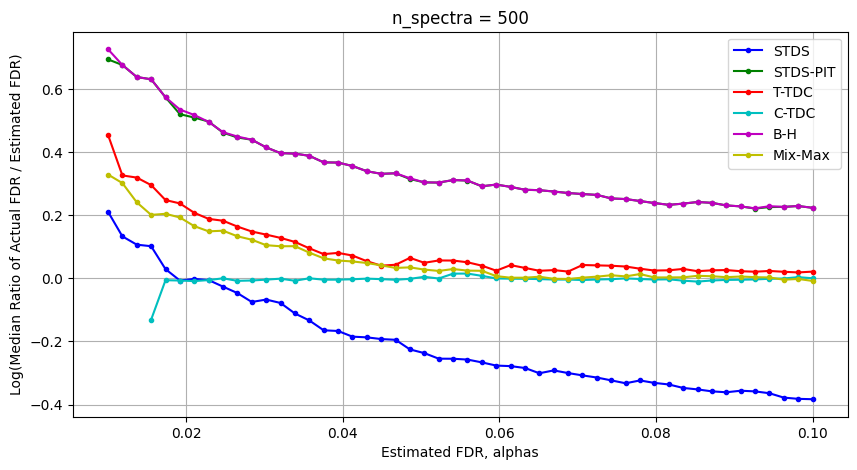

In [ ]:
n_spectra_values = [500]       # [500, 1000, 10000, 30000, 70000]
pi0 = 0.5
N_runs = 1000       # 10k in paper, but takes too long

for n_spectra in n_spectra_values:
    ratio_dict, alpha_values = run_simulations(n_spectra, pi0, N_runs)
    plot_results(ratio_dict, alpha_values, n_spectra)


0.5197


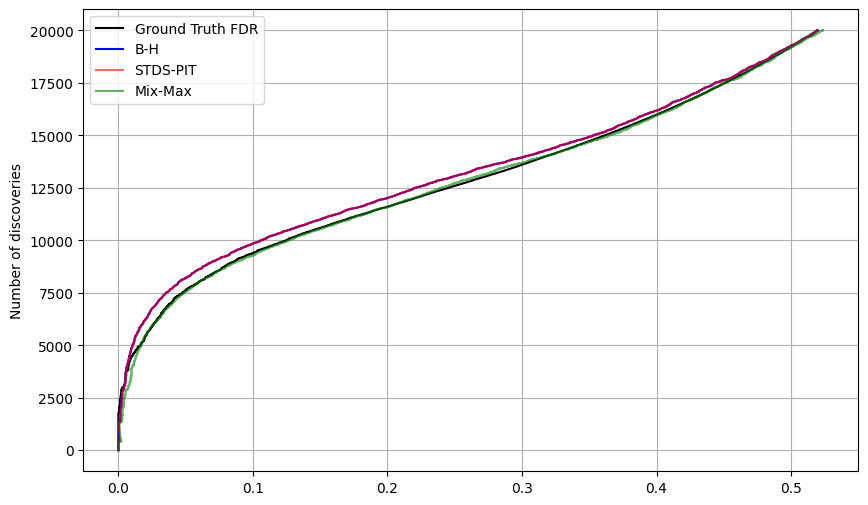

In [ ]:
def plt_qval_vs_disc(Xi, Yi, Zi, Wi, is_correct, pi0):
    sorted_indices = np.argsort(-Wi)
    sorted_scores = Wi[sorted_indices]
    sorted_is_correct = is_correct[sorted_indices]

    ground_truth_fdr = []
    n_disc_truth = []
    for i in range(1, len(Wi) + 1):
        false_disc = np.sum(~sorted_is_correct[:i])
        fdr = false_disc / i
        ground_truth_fdr.append(fdr)
        n_disc_truth.append(i)

    min_q = 1.0
    for i in range(len(ground_truth_fdr)-1, -1, -1):
        min_q = min(min_q, ground_truth_fdr[i])
        ground_truth_fdr[i] = min_q

    # B-H
    n_disc_bh, q_values_bh, actual_fdrs_bh = fdr_bh(Xi, Yi, Zi, Wi, is_correct, pi0)

    # STDS-PIT
    thresholds_pit, est_fdrs_pit, _ = fdr_stds_pit(Xi, Yi, Zi, Wi, is_correct, pi0)
    n_disc_stdspit = [np.sum(Wi >= t) for t in thresholds_pit]

    # MIX_MAX
    thresholds_mm, est_fdrs_mm, _ = fdr_mixmax(Xi, Yi, Zi, Wi, is_correct, pi0)
    n_disc_mm = [np.sum(Wi > t) for t in thresholds_mm]

    n_disc = list(range(1, len(Wi) + 1))

    plt.figure(figsize=(10, 6))
    plt.plot(ground_truth_fdr, n_disc, 'k-', label='Ground Truth FDR')
    plt.plot(q_values_bh, n_disc_bh, 'b-', label='B-H')
    plt.plot(est_fdrs_pit, n_disc_stdspit, 'r-', label='STDS-PIT', alpha=0.6)
    plt.plot(est_fdrs_mm, n_disc_mm, 'g-', label='Mix-Max', alpha=0.6)

    plt.ylabel('Number of discoveries')
    plt.grid(True)
    plt.legend()
    plt.show()


n_spectra = 20000
pi0 = 0.5
Xi, Yi, Zi, Wi, is_correct = simulate_data(n_spectra, pi0)
pi0_obs = 1 - sum(is_correct)/n_spectra
print(pi0_obs)
plt_qval_vs_disc(Xi, Yi, Zi, Wi, is_correct, pi0_obs)

# with true pi0


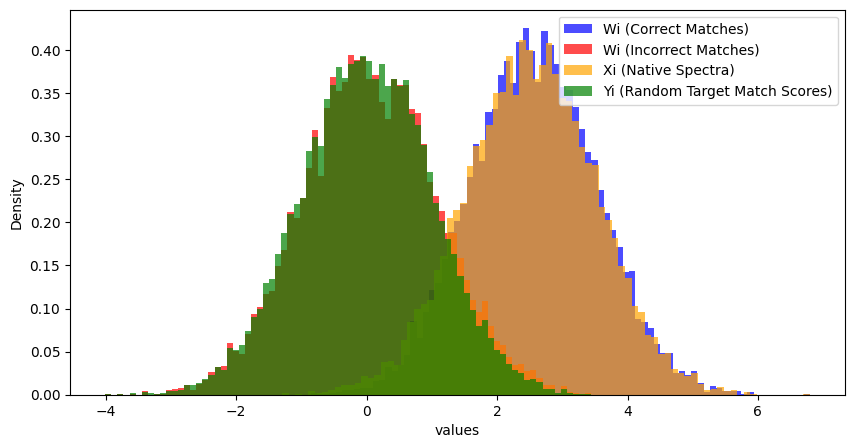

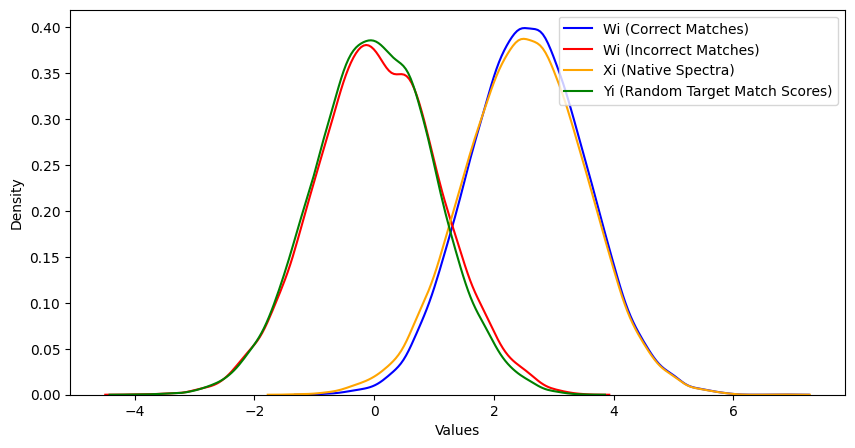

In [ ]:
plt.figure(figsize=(10, 5))
Xi_native = Xi[Xi != -np.inf]

Wi_correct = Wi[is_correct]
Wi_incorrect = Wi[~is_correct]

plt.hist(Wi_correct, bins=80, alpha=0.7, label='Wi (Correct Matches)', color='blue', density=True)
plt.hist(Wi_incorrect, bins=80, alpha=0.7, label='Wi (Incorrect Matches)', color='red', density=True)

plt.hist(Xi_native, bins=80, alpha=0.7, label='Xi (Native Spectra)', color='orange', density=True)
plt.hist(Yi, bins=80, alpha=0.7, label='Yi (Random Target Match Scores)', color='green', density=True)
plt.xlabel('values')
plt.ylabel('Density')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))

sns.kdeplot(Wi_correct, label='Wi (Correct Matches)', color='blue')
sns.kdeplot(Wi_incorrect, label='Wi (Incorrect Matches)', color='red')
sns.kdeplot(Xi_native, label='Xi (Native Spectra)', color='orange')
sns.kdeplot(Yi, label='Yi (Random Target Match Scores)', color='green')

plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()